In [68]:
import pandas as pd
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [51]:
model_dict = torch.load("../scripts/model/model_logs/predictions.pt")
X_scale_train = joblib.load("../Data/statistics/scalar_X_train.pkl")
X_test_scale = joblib.load("../Data/statistics/scalar_X_test.pkl")
y_train_scale = joblib.load("../Data/statistics/scalar_y_train.pkl")
y_test_scale = joblib.load("../Data/statistics/scalar_y_test.pkl")
model = torch.load("../scripts/model/model_6.pt")

In [69]:
import torch.nn as nn
import io

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers ,output_dim):
        super(SimpleNN, self).__init__()
        layers = []
        self.fc1 = layers.append(nn.Linear(input_dim, hidden_dim))
        for layer in range(n_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc2 = layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.ModuleList(layers)          


    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

# Create an instance of the model
# Read the file into a bytes buffer
with open("../scripts/model/model_6.pt", "rb") as f:
    buffer = io.BytesIO(f.read())

# Assuming the buffer has the state_dict
state_dict = torch.load(buffer)

model = SimpleNN(input_dim=14, hidden_dim=40, n_layers=2, output_dim=80)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [70]:
y_test = torch.load("/mnt/home/grunew14/Documents/tardis/emulator/Data/train_data/y_nn_test.pt")
X_test = torch.load("/mnt/home/grunew14/Documents/tardis/emulator/Data/train_data/X_nn_test.pt")

In [71]:
y_predict = model(X_test)
y_predict = y_predict.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()
X_test = X_test.cpu().detach().numpy()

In [72]:
def inverse_transform(X, y, scalers):
    X_unscaled = np.exp(scalers[0].inverse_transform(X))
    y_unscaled = np.exp(scalers[1].inverse_transform(y))
    y_unscaled[:,:40] = np.cumsum(y_unscaled[:,:40], axis=1)
    return X_unscaled, y_unscaled

In [73]:
X_unscaled, y_unscaled = inverse_transform(X_test, y_test, [X_test_scale, y_test_scale])

In [82]:
model_dict.keys()

dict_keys(['predictions', 'actuals', 'X_test'])

In [74]:
_, y_hat = inverse_transform(X_test, y_predict, [X_test_scale, y_test_scale])

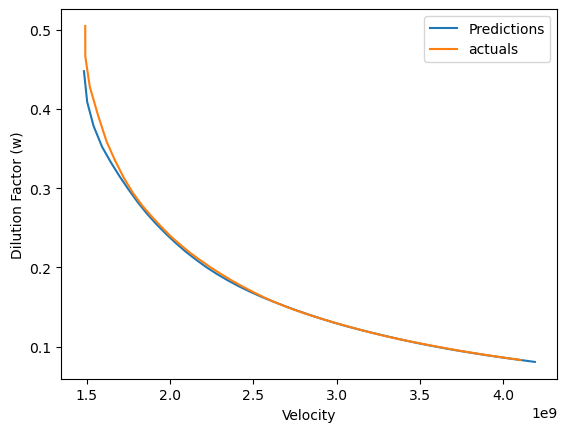

In [75]:
i = 10
plt.plot(y_hat[i, :40], y_hat[i, 40:], label="Predictions")
plt.plot(y_unscaled[i, :40], y_unscaled[i, 40:], label="actuals")
plt.xlabel("Velocity")
plt.ylabel("Dilution Factor (w)")
plt.legend()
plt.show()

# Worst and best predictions

In [82]:
def loghist(data, *args, **kwargs):
    _, bins = np.histogram(np.log10(data))
    plt.hist(data, bins=10**bins, *args, **kwargs)
    plt.xscale('log')

In [83]:
rmse =  np.mean((y_unscaled - y_hat)**2, axis = 1)
len(rmse)

34940

In [84]:
mean_fe = np.mean(np.abs((y_hat - y_unscaled))/y_unscaled, axis=1)
max_fe = np.max(np.abs((y_hat - y_unscaled))/y_unscaled, axis=1)

In [85]:
_, bins_mean_fe = np.histogram(np.log10(mean_fe), bins=100)
_, bins_max_fe = np.histogram(np.log10(max_fe), bins=100)

In [86]:
worst_rmse_idx = np.argmax(rmse)
best_rmse_idx = np.argmin(rmse)

## Demonstration plot

In [87]:
# Define a colorblind-friendly color palette
tableau_colorblind = [(0, 107/255, 164/255),  # blue
                      (255/255, 128/255, 14/255),  # orange
                      (89/255, 89/255, 89/255),  # gray
                      (95/255, 158/255, 209/255),  # light-blue
                      (200/255, 82/255, 0),  # dark-orange
                      (137/255, 137/255, 137/255),  # light-gray
                      # Add more colors from the palette if needed
                      ]


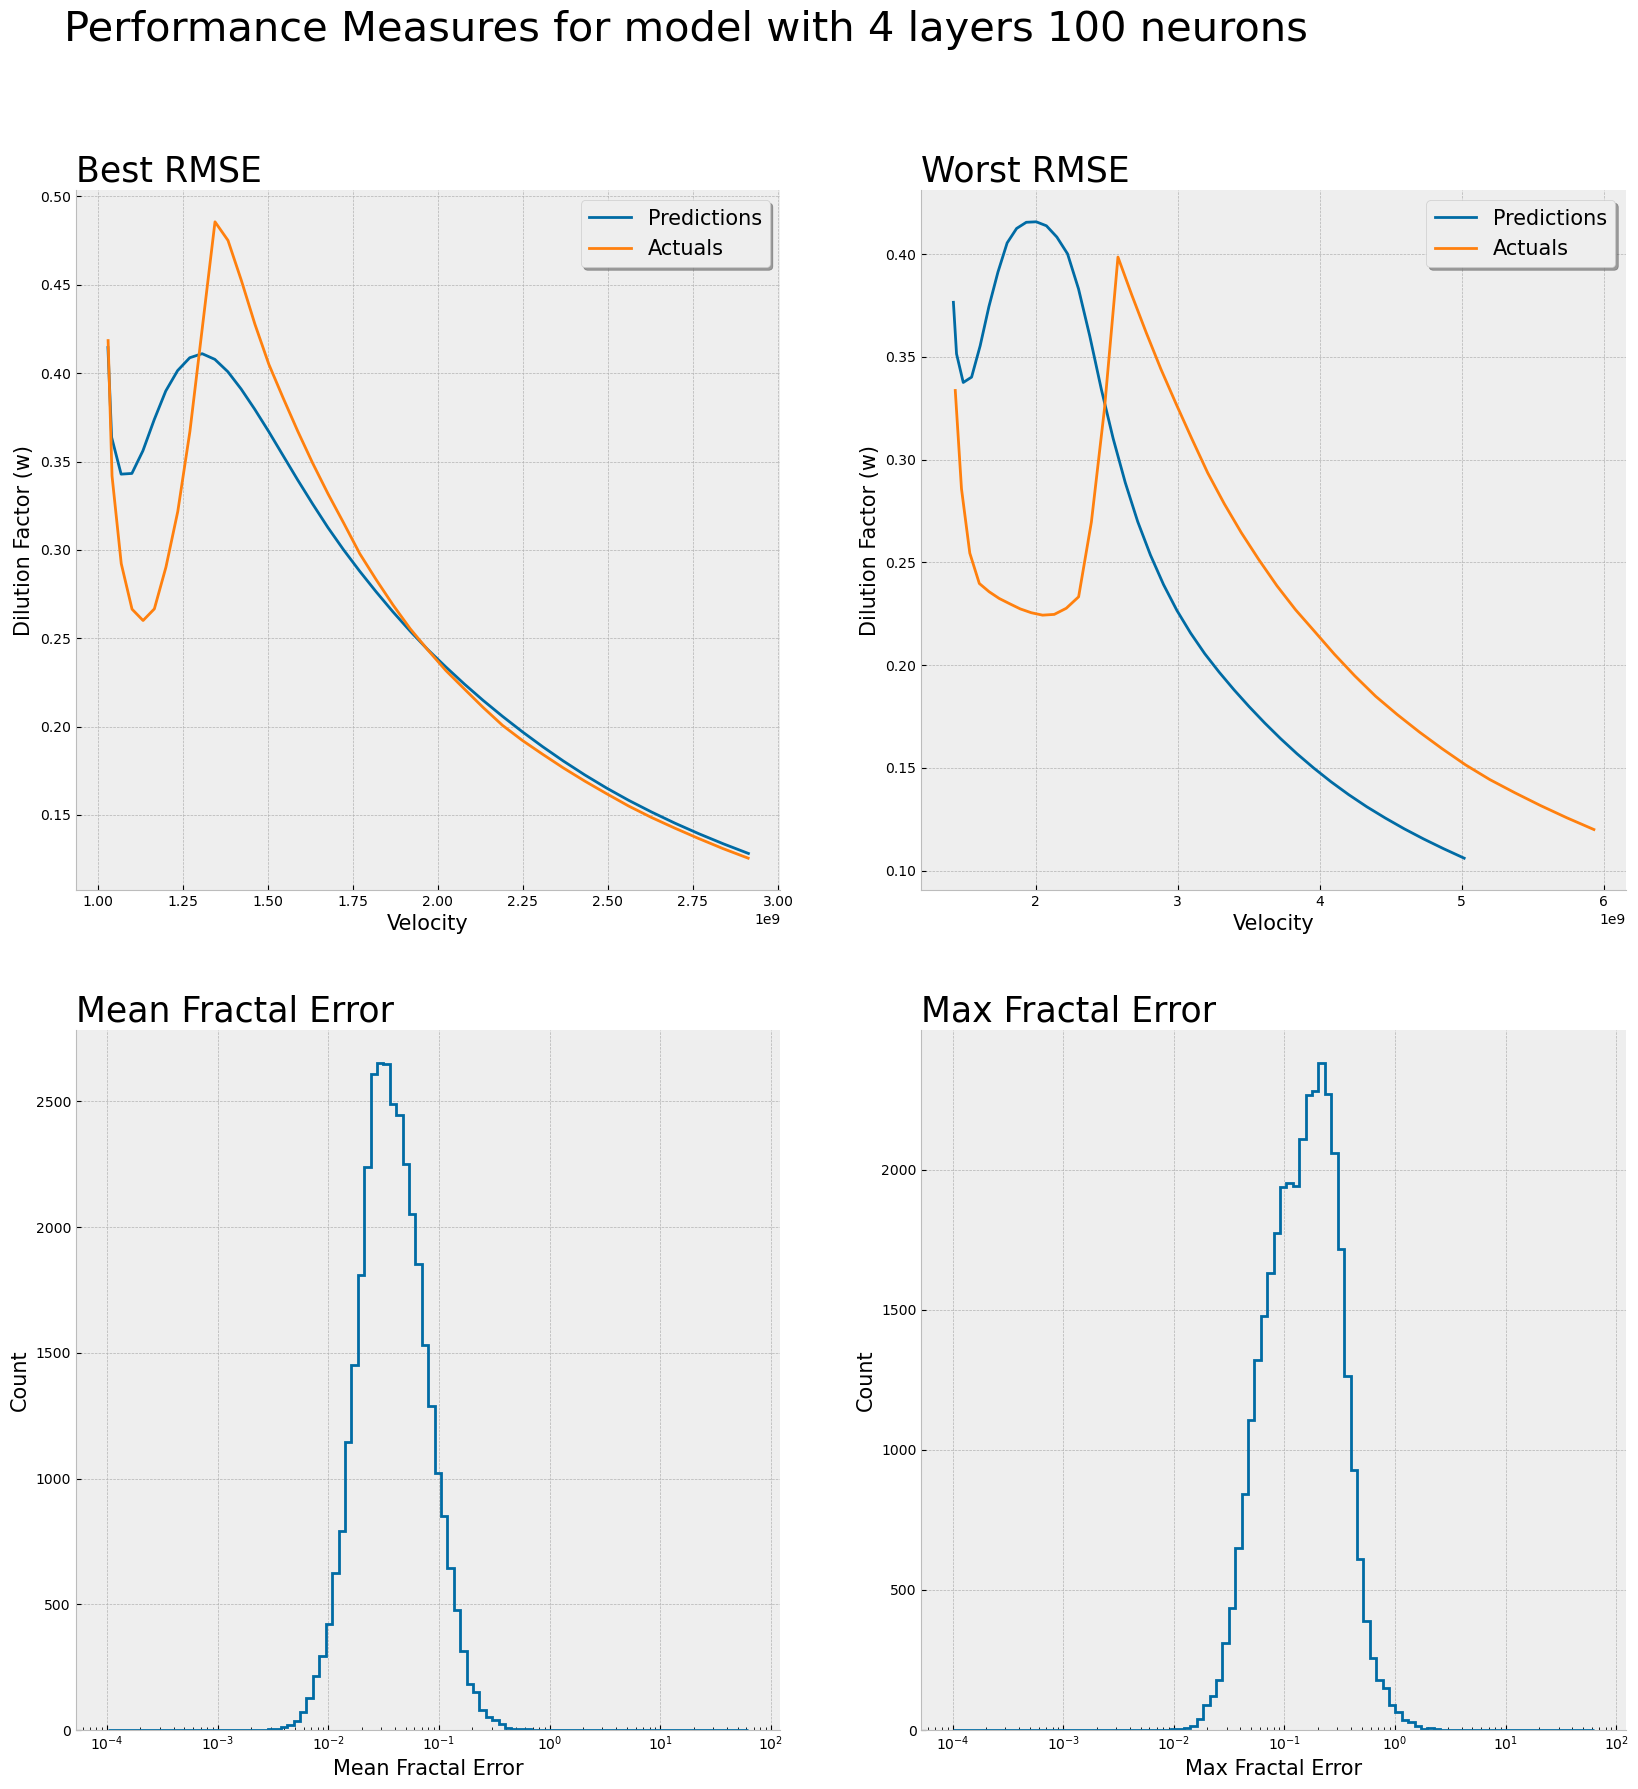

In [88]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(2,2, figsize=(20,20))
    ax[0,0].plot(y_hat[best_rmse_idx,:40], y_hat[best_rmse_idx,40:], label = "Predictions", color=tableau_colorblind[0])
    ax[0,0].plot(y_unscaled[best_rmse_idx,:40], y_unscaled[best_rmse_idx,40:], label = "Actuals", color=tableau_colorblind[1])
    ax[0,0].spines["top"].set_visible(False)
    ax[0,0].spines["right"].set_visible(False)
    ax[0,0].set_xlabel("Velocity", fontsize=15)
    ax[0,0].set_ylabel("Dilution Factor (w)", fontsize=15)
    ax[0,0].legend(frameon = True, fancybox=True, shadow=True, fontsize=15)
    ax[0,0].set_title("Best RMSE", fontsize=25, loc="left")
    
    ax[0,1].plot(y_hat[worst_rmse_idx,:40], y_hat[worst_rmse_idx,40:], label = "Predictions", color=tableau_colorblind[0])
    ax[0,1].plot(y_unscaled[worst_rmse_idx,:40], y_unscaled[worst_rmse_idx,40:], label = "Actuals", color=tableau_colorblind[1])
    ax[0,1].spines["top"].set_visible(False)
    ax[0,1].spines["right"].set_visible(False)
    ax[0,1].set_xlabel("Velocity", fontsize=15)
    ax[0,1].set_ylabel("Dilution Factor (w)", fontsize=15)
    ax[0,1].legend(frameon = True, fancybox=True, shadow=True, fontsize=15)
    ax[0,1].set_title("Worst RMSE", fontsize=25, loc="left")

    ax[1,0].hist(mean_fe, bins=100**bins_max_fe, histtype="step", label="Mean Fe", color=tableau_colorblind[0], lw=2)
    ax[1,0].set_xscale("log")
    ax[1,0].set_ylabel("Count", fontsize=15)
    ax[1,0].set_xlabel("Mean Fractal Error", fontsize=15)
    ax[1,0].spines["top"].set_visible(False)
    ax[1,0].spines["right"].set_visible(False)
    ax[1,0].set_title("Mean Fractal Error", fontsize=25, loc="left")

    ax[1,1].hist(max_fe, bins=100**bins_max_fe, histtype="step", label="Mean Fe", color=tableau_colorblind[0], lw = 2)
    ax[1,1].set_ylabel("Count", fontsize=15)
    ax[1,1].set_xscale("log")
    ax[1,1].set_xlabel("Max Fractal Error", fontsize=15)
    ax[1,1].spines["top"].set_visible(False)
    ax[1,1].spines["right"].set_visible(False)
    ax[1,1].set_title("Max Fractal Error", fontsize=25, loc="left")

    fig.suptitle("Performance Measures for model with 4 layers 100 neurons", fontsize=30, y=0.97, x=0.43)
    



    


In [36]:
def loghist(data, *args, **kwargs):
    _, bins = np.histogram(np.log10(data))
    plt.hist(data, bins=10**bins, *args, **kwargs)
    plt.xscale('log')

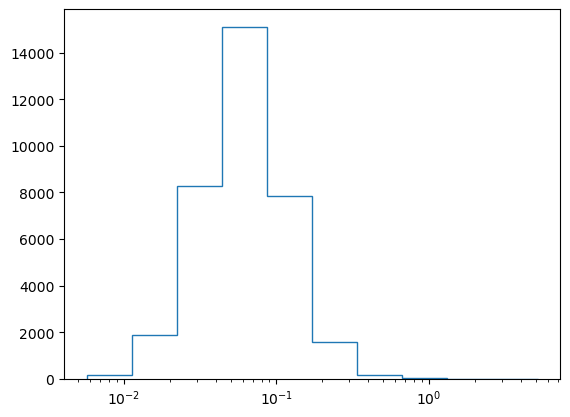

In [39]:
loghist(max_fe, histtype = "step")

In [40]:
def func(*args, **kwargs):
    return args, kwargs
func(1, 2, 3, a=4, b=5, c=6)

((1, 2, 3), {'a': 4, 'b': 5, 'c': 6})